In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
raw = pd.read_csv('./data/secondary_data.csv', sep=';')

## Data preprocessing

In [3]:
# we count the number of missing values per column
nas = raw.isna().sum()
nas

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-spacing            25063
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51538
stem-surface            38124
stem-color                  0
veil-type               57892
veil-color              53656
has-ring                    0
ring-type                2471
spore-print-color       54715
habitat                     0
season                      0
dtype: int64

In [4]:
# select columns with >40% of the rows missing
columns_missing = nas.loc[nas > 0.4*len(raw)]
columns_missing

gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
spore-print-color    54715
dtype: int64

In [5]:
# drop columns with high volume of missing rows
data = raw.drop(columns_missing.index, axis=1)
data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,f,e,w,16.95,17.09,w,t,g,d,w
1,p,16.60,x,g,o,f,e,w,17.99,18.19,w,t,g,d,u
2,p,14.07,x,g,o,f,e,w,17.80,17.74,w,t,g,d,w
3,p,14.17,f,h,e,f,e,w,15.77,15.98,w,t,p,d,w
4,p,14.64,x,h,o,f,e,w,16.53,17.20,w,t,p,d,w


### Data processing

In [6]:
# split into X and y
# for y: 'p' is poisonous, 'e' is edible
y = data['class'].apply(lambda x: x == 'p').astype(int)
X_raw = data.drop(['class'], axis=1)
# has-ring is a boolean so we can process it directly
X_raw['has-ring'] = X_raw['has-ring'].apply(lambda x: x == 't').astype(int)

# select categorical and numerical columns
cat = X_raw.select_dtypes('object').columns
num = ['cap-diameter', 'stem-height', 'stem-width']

#### Imputing missing data

In [7]:
# the remaining missing values
missing_cols = X_raw.columns[X_raw.isna().any()].tolist()
X_raw[cat].isna().sum()

cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9884
gill-color                  0
stem-color                  0
ring-type                2471
habitat                     0
season                      0
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion

# to impute strings we do not have much choice
# especially given the high amount of missing values
# we will replace missings with the most frequent value of each column
# we will also add a 'missing indicator' to the dataframe,
# a sparse boolean matrix showing which features were missing beforehand
# this will allow our estimator to take missing values into consideration
imputer = FeatureUnion(
     transformer_list=[
         ('features', SimpleImputer(strategy='most_frequent')),
         ('indicators', MissingIndicator())
    ]
)

x_imp = imputer.fit_transform(X_raw[cat])
# we can show a sample of how this would look
df_imp = pd.DataFrame(data=x_imp, columns=[*cat, *[f'missing_{missing_cols[i]}' for i in range(x_imp.shape[1]-len(cat))]])
print('Count of missing values on categorical columns:')
print(df_imp[cat].isna().sum())
print('\nMissing indicators:')
print(df_imp.filter(regex='^missing_\d').sum())
df_imp.head()

Count of missing values on categorical columns:
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-color              0
ring-type               0
habitat                 0
season                  0
dtype: int64

Missing indicators:
Series([], dtype: float64)


,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-color,ring-type,habitat,season,missing_cap-surface,missing_gill-attachment,missing_ring-type
0,x,g,o,f,e,w,w,g,d,w,False,False,False
1,x,g,o,f,e,w,w,g,d,u,False,False,False
2,x,g,o,f,e,w,w,g,d,w,False,False,False
3,f,h,e,f,e,w,w,p,d,w,False,False,False
4,x,h,o,f,e,w,w,p,d,w,False,False,False


In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# we make data pipelines for numerical & categorical variables
num_pipeline = Pipeline([
        # standardize numerical values
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        # impute missing values + add missing indicators
        ('imputer', imputer),
        # encode strings as ints
        ('ord_enc', OrdinalEncoder())
    ])

In [10]:
# apply the pipeline
full_pipeline = ColumnTransformer([
         ('num', num_pipeline, num),
         ('cat', cat_pipeline, cat),
     ])
X = full_pipeline.fit_transform(X_raw)
df_processed = pd.DataFrame(data=X, columns=
                            [*num, *cat,
                             *[f'missing_{missing_cols[i]}' for i in range(X.shape[1]-X_raw.shape[1]+1)]]
                           )

column_names = list(df_processed.columns)

### Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((40916, 16), (20153, 16))

## Gradient boosting

### XGBoost

In [12]:
from xgboost import XGBClassifier

bst = XGBClassifier(booster = 'dart', n_estimators=250, max_depth=7, learning_rate=0.1, rate_drop = 0.2, objective='binary:logistic')

In [13]:
bst.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
from sklearn.metrics import accuracy_score

preds = bst.predict(X_test)
f'Accuracy (test) for XGBoost {accuracy_score(preds, y_test)*100:.2f}'

'Accuracy (test) for XGBoost 96.66'

#### Feature importance

In [82]:
feat_imp_df = pd.DataFrame(data=[bst.feature_importances_], columns=column_names).melt()
feat_imp_df = feat_imp_df.sort_values('value')

Text(0.5, 1.0, 'XGBoost feature importances')

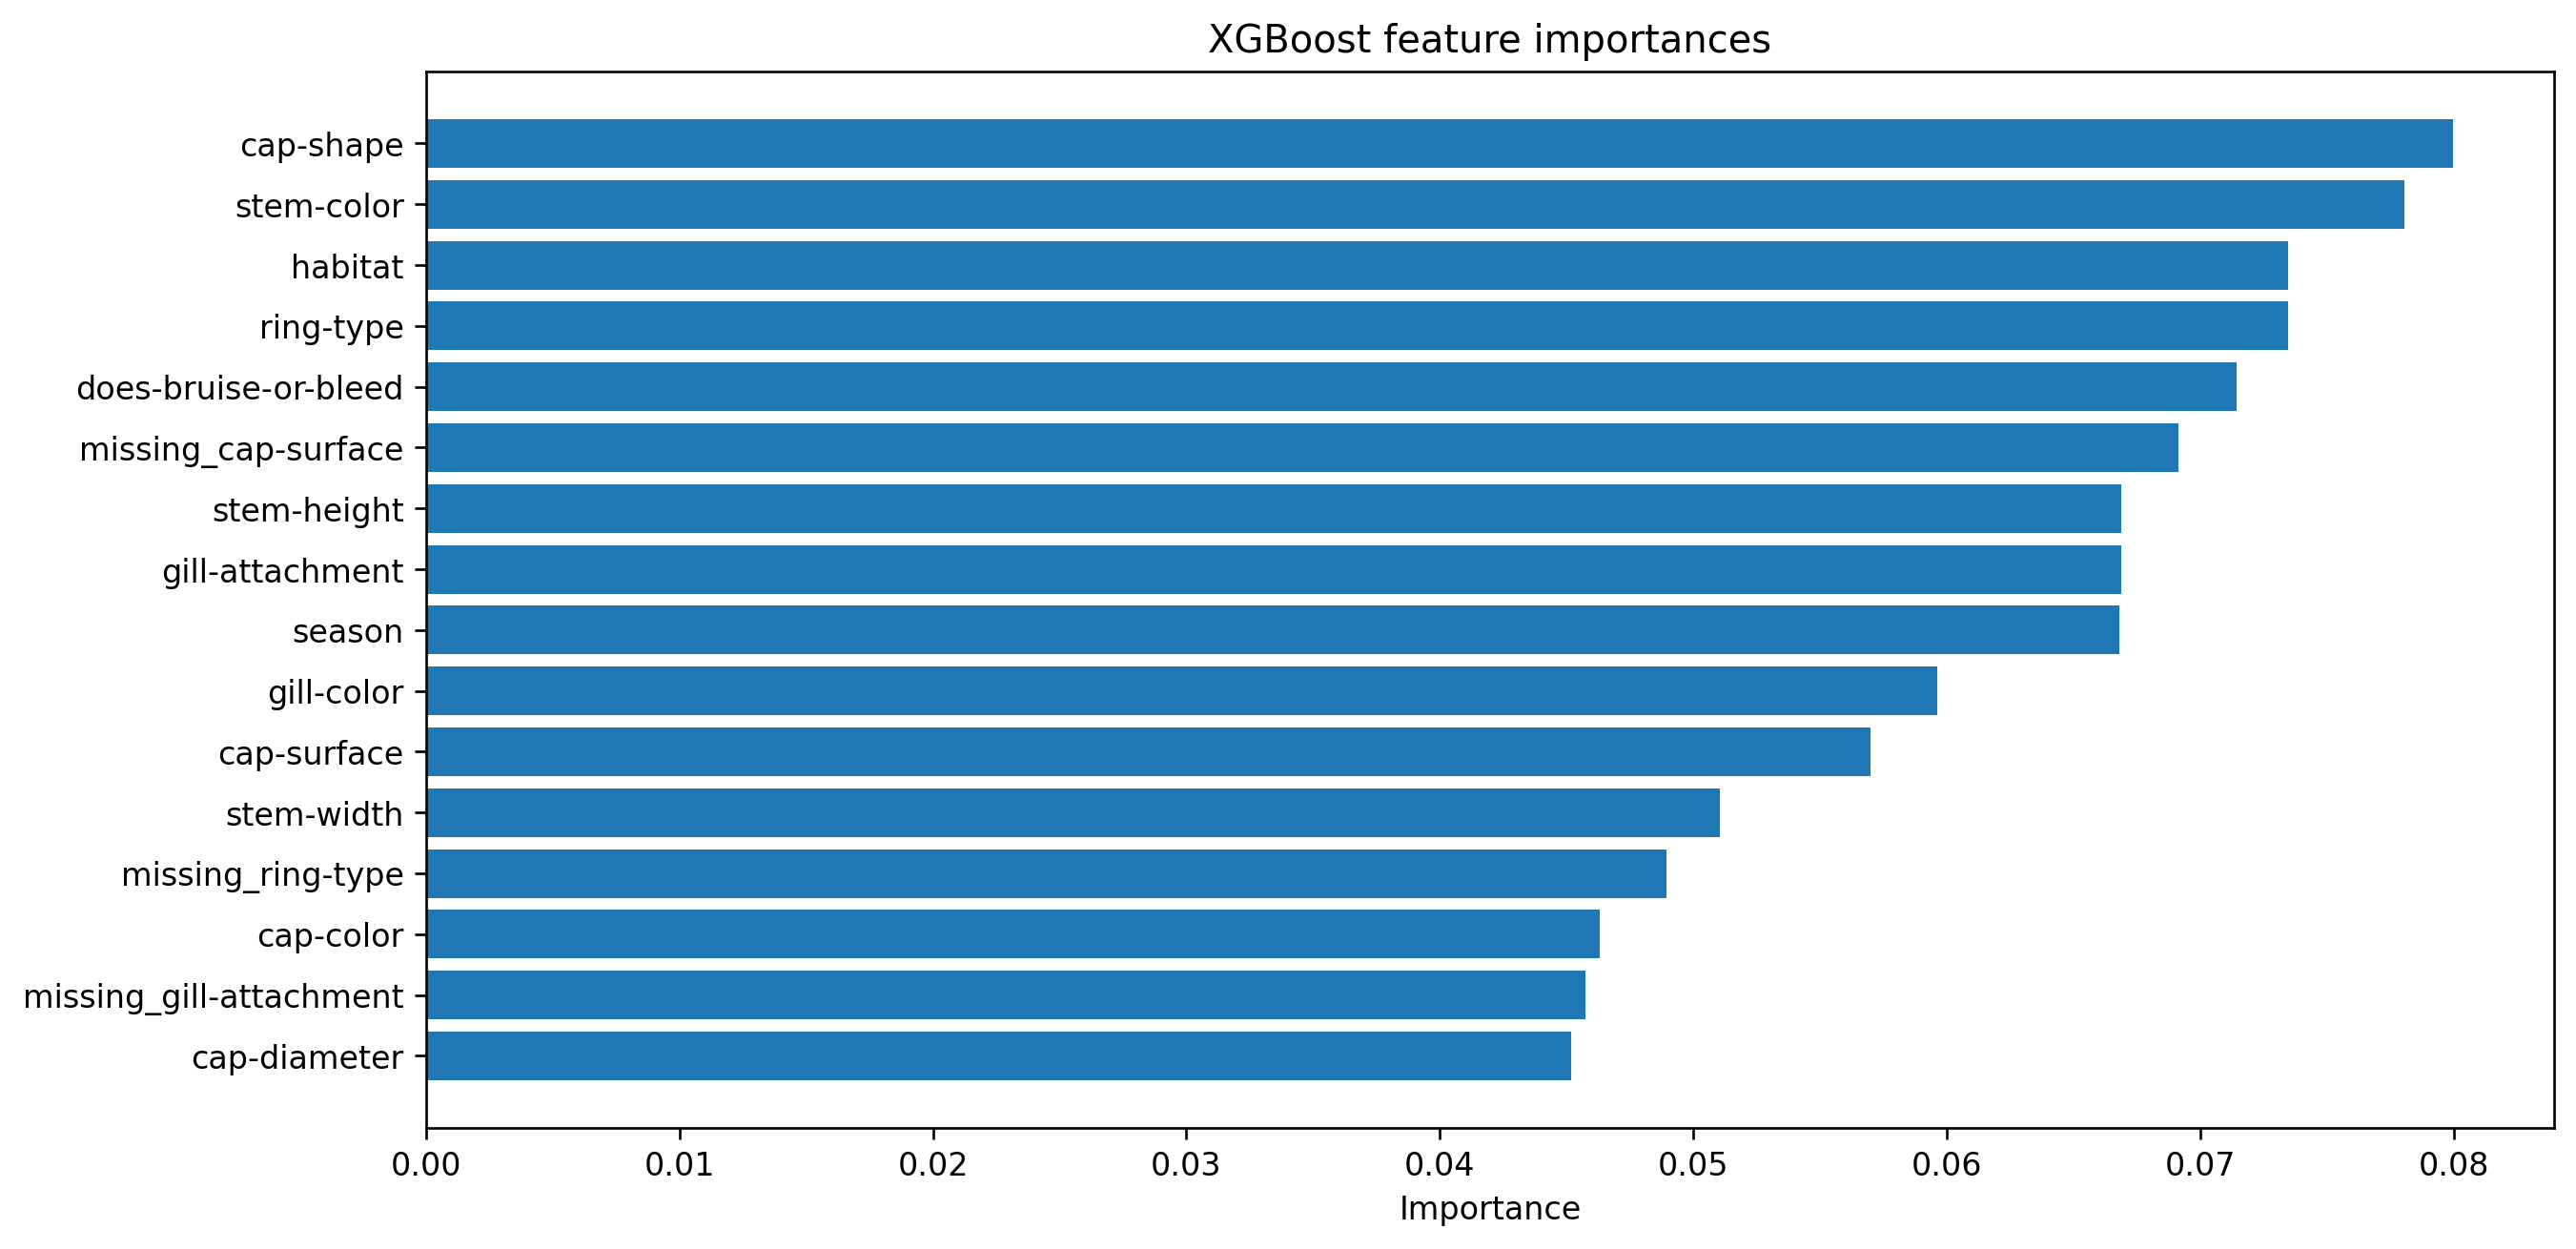

In [93]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=240)

y_pos = np.arange(len(feat_imp_df))

ax.barh(y_pos, feat_imp_df.value)
ax.set_yticks(y_pos, labels=feat_imp_df.variable)
ax.set_xlabel('Importance')
ax.set_title('XGBoost feature importances')

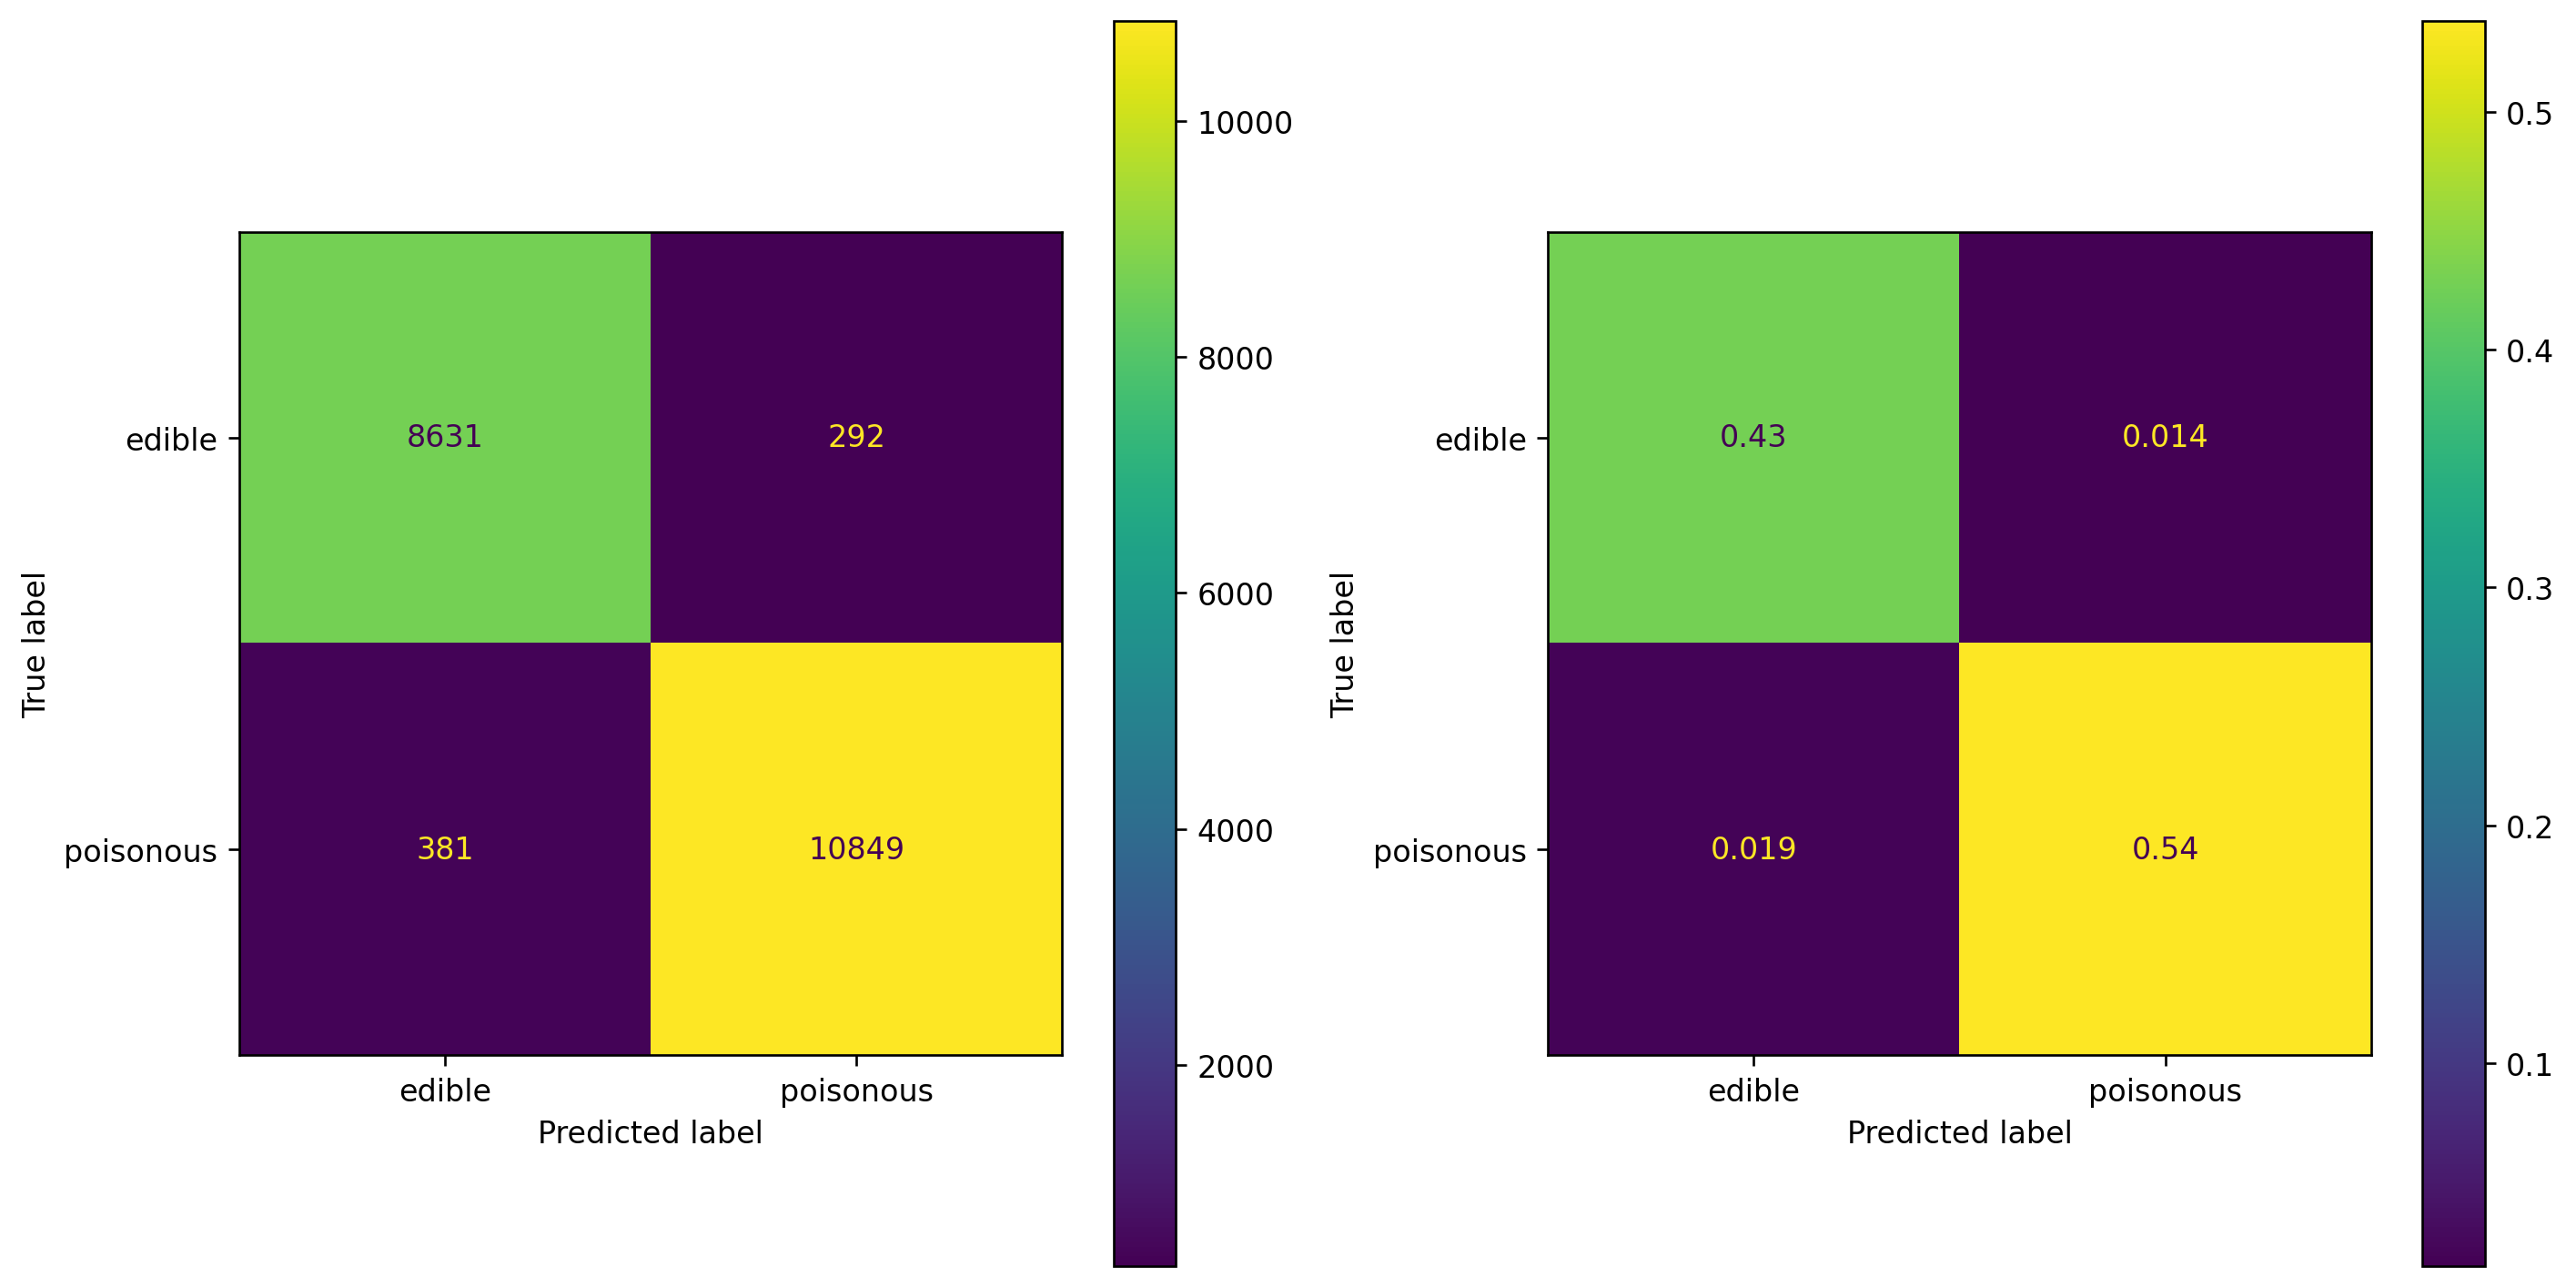

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#poisonous = 1, edible = 0

#confusion matrix
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), dpi=240)
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['edible', 'poisonous'], ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='all', display_labels=['edible', 'poisonous'], ax=axs[1])
plt.tight_layout()

## Neural network

In [17]:
import tensorflow as tf
from tensorflow import keras

2023-01-08 12:31:44.107089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
 tf.random.set_seed(42)

In [19]:
# simple model with 3 dense layers
# some dropout layers are added in between to help prevent overfitting
# the final layer has a sigmoid activation, since we are looking for a binary classification
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4352      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 334,337
Trainable params: 334,337
Non-trai

2023-01-08 12:31:50.617173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Custom metrics

In [20]:
import keras.backend as K

# custom metric to combine recall and specificity with given weights for both
def weighted_recall_spec(recall_weight, spec_weight):
    def recall_specificity(y_true, y_pred):
        TN = tf.logical_and(y_true == 0, y_pred == 0)
        TP = tf.logical_and(y_true == 1, y_pred == 1)

        FP = tf.logical_and(y_true == 0, y_pred == 1)
        FN = tf.logical_and(y_true == 1, y_pred == 0)

        TN = K.sum(K.cast(TN, K.floatx()))
        FP = K.sum(K.cast(FP, K.floatx()))
        TP = K.cast(TP, K.floatx())
        FN = K.cast(FN, K.floatx())

        specificity = TN / (TN + FP + K.epsilon())
        recall = TP / (TP + FN + K.epsilon())

        return 1.0 - (recall_weight*recall + spec_weight*specificity)

    return recall_specificity

In [21]:
# here we create the actual metric function - in our case we want high recall and lower specificity
recall_spec = weighted_recall_spec(recall_weight=0.7, spec_weight=0.3)

### Training

In [22]:
# compile the model, we add five extra metrics for later use in plotting and analysis of the model
adam = keras.optimizers.Adam(learning_rate=1e-2)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[
                       keras.metrics.FalseNegatives(name='false_negatives'),
                       keras.metrics.FalsePositives(name='false_positives'),
                       keras.metrics.TrueNegatives(name='true_negatives'),
                       keras.metrics.TruePositives(name='true_positives'),
                       recall_spec]
             )

In [23]:
# reduce false_negatives by giving more weight to the poisonous class
class_weight = {0: 0.3, 1: 0.7}

In [24]:
# callback to stop the model if the false negatives stop decreasing for 10 epochs or more
early_stop = keras.callbacks.EarlyStopping(monitor='false_negatives', patience=10)

In [25]:
# train the net
history = model.fit(X_train, y_train,
                    validation_split=0.1, epochs=50, batch_size=32,
                    callbacks=[early_stop], class_weight=class_weight)

/Users/szeth/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
1151/1151 [==============================] - 6s 4ms/step - loss: 0.1778 - false_negatives: 1164.0000 - false_positives: 7362.0000 - true_negatives: 9107.0000 - true_positives: 19191.0000 - recall_specificity: 0.9935 - val_loss: 0.1954 - val_false_negatives: 164.0000 - val_false_positives: 131.0000 - val_true_negatives: 1658.0000 - val_true_positives: 2139.0000 - val_recall_specificity: 0.9742
Epoch 2/50
1151/1151 [==============================] - 5s 4ms/step - loss: 0.0666 - false_negatives: 570.0000 - false_positives: 1828.0000 - true_negatives: 14641.0000 - true_positives: 19785.0000 - recall_specificity: 0.9443 - val_loss: 0.1231 - val_false_negatives: 9.0000 - val_false_positives: 183.0000 - val_true_negatives: 1606.0000 - val_true_positives: 2294.0000 - val_recall_specificity: 0.9299
Epoch 3/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0385 - false_negatives: 339.0000 - false_positives: 995.0000 - true_negatives: 15474.0000 - true_positives: 20

1151/1151 [==============================] - 5s 5ms/step - loss: 0.0064 - false_negatives: 51.0000 - false_positives: 132.0000 - true_negatives: 16337.0000 - true_positives: 20304.0000 - recall_specificity: 0.6947 - val_loss: 0.0177 - val_false_negatives: 2.0000 - val_false_positives: 20.0000 - val_true_negatives: 1769.0000 - val_true_positives: 2301.0000 - val_recall_specificity: 0.7129
Epoch 22/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0075 - false_negatives: 53.0000 - false_positives: 120.0000 - true_negatives: 16349.0000 - true_positives: 20302.0000 - recall_specificity: 0.7280 - val_loss: 0.0326 - val_false_negatives: 2.0000 - val_false_positives: 35.0000 - val_true_negatives: 1754.0000 - val_true_positives: 2301.0000 - val_recall_specificity: 0.7190
Epoch 23/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0071 - false_negatives: 49.0000 - false_positives: 131.0000 - true_negatives: 16338.0000 - true_positives: 20306.0000 - recall_

1151/1151 [==============================] - 4s 4ms/step - loss: 0.0051 - false_negatives: 52.0000 - false_positives: 96.0000 - true_negatives: 16373.0000 - true_positives: 20303.0000 - recall_specificity: 0.5854 - val_loss: 0.0051 - val_false_negatives: 0.0000e+00 - val_false_positives: 10.0000 - val_true_negatives: 1779.0000 - val_true_positives: 2303.0000 - val_recall_specificity: 0.5096
Epoch 42/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0047 - false_negatives: 36.0000 - false_positives: 89.0000 - true_negatives: 16380.0000 - true_positives: 20319.0000 - recall_specificity: 0.5570 - val_loss: 0.0056 - val_false_negatives: 0.0000e+00 - val_false_positives: 5.0000 - val_true_negatives: 1784.0000 - val_true_positives: 2303.0000 - val_recall_specificity: 0.5779
Epoch 43/50
1151/1151 [==============================] - 4s 4ms/step - loss: 0.0044 - false_negatives: 31.0000 - false_positives: 81.0000 - true_negatives: 16388.0000 - true_positives: 20324.0000 - rec

## Model comparison

In [26]:
# see how well it performs on the test set
model.evaluate(X_test, y_test)

630/630 [==============================] - 1s 1ms/step - loss: 0.0129 - false_negatives: 6.0000 - false_positives: 77.0000 - true_negatives: 8846.0000 - true_positives: 11224.0000 - recall_specificity: 0.6195


[0.012940958142280579, 6.0, 77.0, 8846.0, 11224.0, 0.6195006966590881]

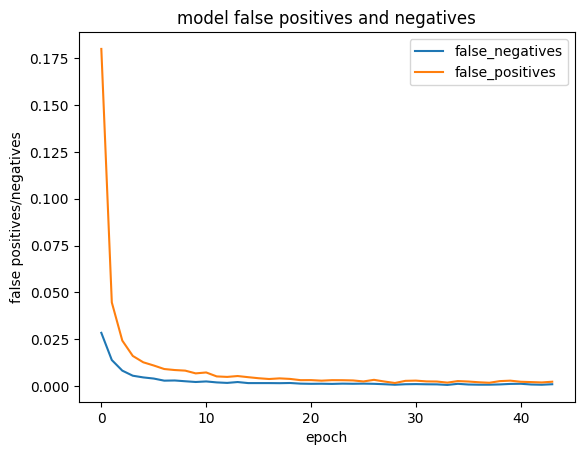

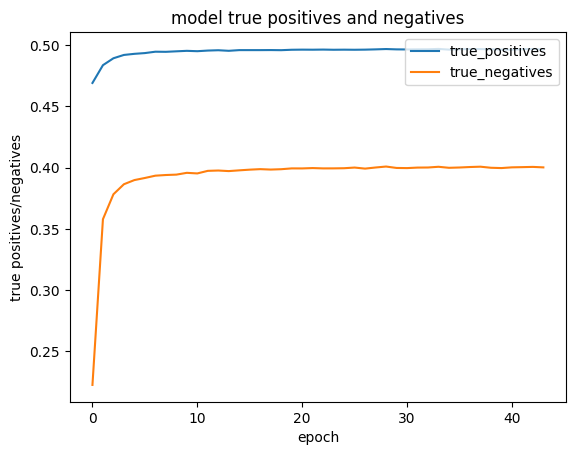

In [27]:
N = len(X_train)
# we plot the (percentages of) false negatives and false positives.
# we are mostly interested in false negatives, that is,
# the model saying a mushroom is not poisonous when it is (bad for the end user)
plt.plot(np.array(history.history['false_negatives']) / N, label='false_negatives')
plt.plot(np.array(history.history['false_positives']) / N, label='false_positives')

#plt.plot(np.array(history.history['val_false_negatives_2']) / (N * 0.1))
plt.title('model false positives and negatives')
plt.ylabel('false positives/negatives')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# we also plot the true positives and negatives,
# which we want to keep as high as possible (correct classifications)

plt.plot(np.array(history.history['true_positives']) / N, label='true_positives')
plt.plot(np.array(history.history['true_negatives']) / N, label='true_negatives')
plt.title('model true positives and negatives')
plt.ylabel('true positives/negatives')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

630/630 [==============================] - 1s 929us/step


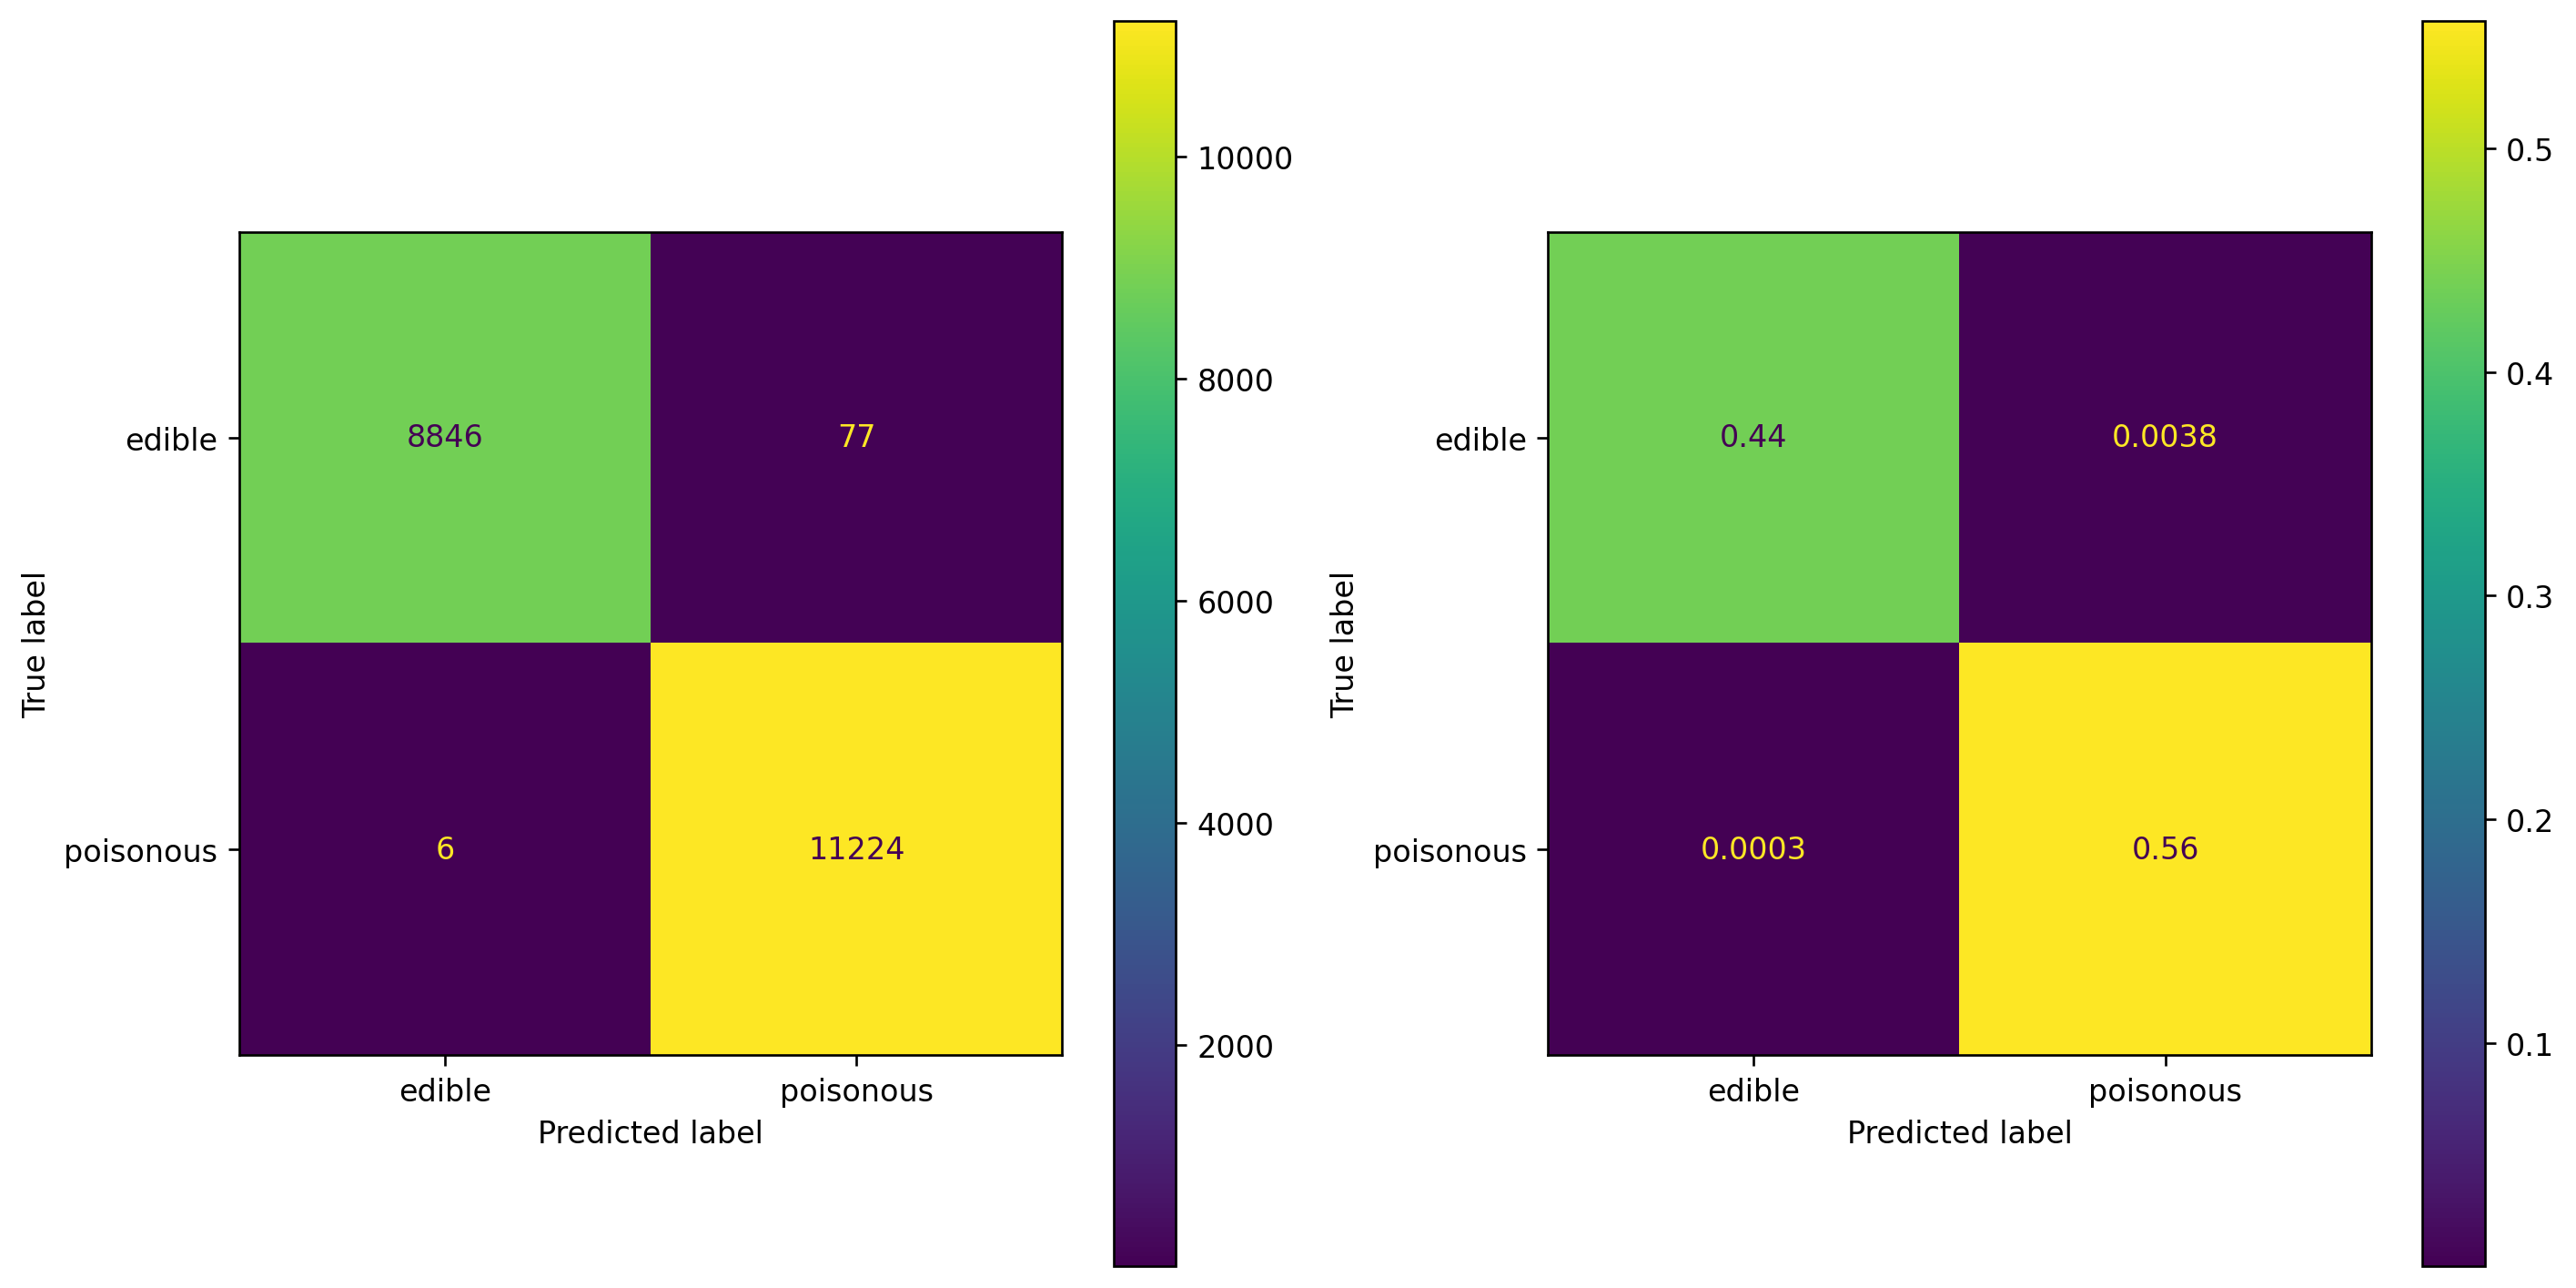

In [31]:
preds = model.predict(X_test).round()

fig, axs = plt.subplots(ncols=2, figsize=(12, 6), dpi=240)
ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['edible', 'poisonous'], ax=axs[0])
ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='all', display_labels=['edible', 'poisonous'], ax=axs[1])
plt.tight_layout()

In [32]:
# get the false negative percentage when evaluating on the total dataset and on the test set
# the latter is more realistic, as the model may have 'memorized' some entries on the total set
fn_total = model.evaluate(X, y)[1] / len(X)
fn_test = model.evaluate(X_test, y_test)[1] / len(X_test)

630/630 [==============================] - 1s 1ms/step - loss: 0.0129 - false_negatives: 6.0000 - false_positives: 77.0000 - true_negatives: 8846.0000 - true_positives: 11224.0000 - recall_specificity: 0.6195


In [33]:
# important for the user to know
'Your chance of dying if you ate a mushroom classified by our model is ' + \
f'total={fn_total*100:.3f}% (out of {len(X)}) test={fn_test*100:.3f}% (out of {len(X_test)})'

'Your chance of dying if you ate a mushroom classified by our model is total=0.041% (out of 61069) test=0.030% (out of 20153)'

In [40]:
f'Accuracy for net={accuracy_score(y_test, preds)*100:.2f}%'

'Accuracy for net=99.59%'

## Feature importance

In [33]:
import shap

/Users/szeth/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
explainer = shap.KernelExplainer(model, shap.sample(X_train, 100))

In [44]:
shap_values = explainer.shap_values(X_test[:10])

100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


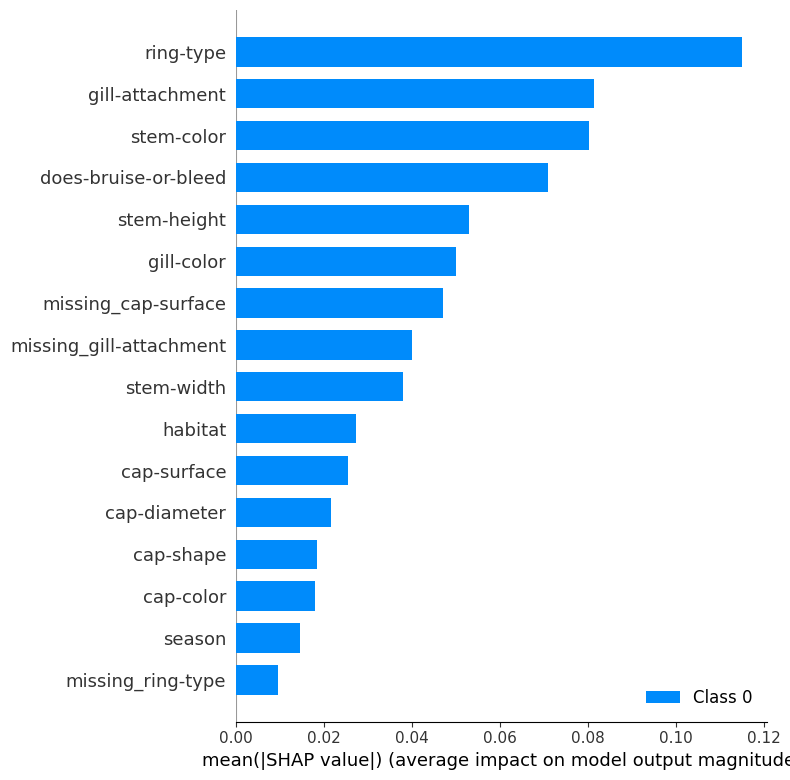

In [129]:
shap.initjs()
# feature importances
shap.summary_plot(shap_values, features=column_names, plot_type="bar")

In [130]:
i = 2
# importance of each variable on i'th datapoint
shap.plots.force(explainer.expected_value, shap_values[0][i], features=column_names)

In [131]:
# importance of each variable over multiple datapoints
shap.force_plot(explainer.expected_value, shap_values[0][:10], features=column_names)